In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install scikit-surprise

**Preprocessing Data**

- Read data
- Filter and clean data

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
ratings = pd.read_csv('/content/drive/My Drive/Colab Notebooks/MovieLens/ml-latest-small/ratings.csv')
movies = pd.read_csv('/content/drive/My Drive/Colab Notebooks/MovieLens/ml-latest-small/movies.csv')
tags = pd.read_csv('/content/drive/My Drive/Colab Notebooks/MovieLens/ml-latest-small/tags.csv')

In [0]:
movies['genres'] = movies['genres'].str.replace('|',' ')

In [0]:
ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 55)
movie_list_rating = ratings_f.movieId.unique().tolist()

In [0]:
len(ratings_f.movieId.unique())/len(movies.movieId.unique()) * 100

98.7990145760624

In [0]:
len(ratings_f.userId.unique())/len(ratings.userId.unique()) * 100

59.67213114754099

In [0]:
movies = movies[movies.movieId.isin(movie_list_rating)]

In [0]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [0]:
# map movie to id:
Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

In [0]:
tags.drop(['timestamp'],1, inplace=True)
ratings_f.drop(['timestamp'],1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
mixed = pd.merge(movies, tags, on='movieId', how='left')
mixed.head()

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun
3,2,Jumanji (1995),Adventure Children Fantasy,62.0,fantasy
4,2,Jumanji (1995),Adventure Children Fantasy,62.0,magic board game


In [0]:
# create metadata from tags and genres
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
Final = pd.merge(movies, mixed, on='movieId', how='left')
Final ['metadata'] = Final[['tag', 'genres']].apply(lambda x: ' '.join(x), axis = 1)
Final[['movieId','title','metadata']].head()

,movieId,title,metadata
0,1,Toy Story (1995),pixar pixar fun Adventure Animation Children C...
1,2,Jumanji (1995),fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men (1995),moldy old Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),pregnancy remake Comedy


**Memory based Collaborative Filtering**

- K-nearest Neighbors on user rating  matrix

In [0]:
ratings_f.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [0]:
ratings_f1 = pd.merge(movies[['movieId']], ratings_f, on="movieId", how="right")
ratings_f2 = ratings_f1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)
ratings_f2.head(3)

userId,1,4,6,7,10,11,15,16,17,18,19,20,21,22,23,24,27,28,29,32,33,34,36,38,39,40,41,42,43,45,47,50,51,52,57,58,59,62,63,64,...,558,559,560,561,562,563,564,566,567,570,571,572,573,577,579,580,582,583,584,585,586,587,588,590,592,593,594,596,597,599,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,4.0,0.0,3.5,0.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,4.0,0.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,4.0,...,0.0,5.0,3.0,4.0,4.5,0.0,0.0,0.0,3.5,4.0,0.0,4.0,5.0,0.0,4.0,3.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,4.0,4.0,3.0,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,4.0,0.0,2.5,0.0,4.0,0.0,3.5,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,4.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [0]:
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold

model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

kf = KFold(n_splits=10)

for train_index, test_index in kf.split(ratings_f2):
  model_knn.fit(ratings_f2.iloc[train_index])
  distances, indices = model_knn.kneighbors(ratings_f2.iloc[test_index], n_neighbors= 1)
  print('Average Distance : %lf'%(np.sum(distances)/test_index.shape[0]))

Average Distance : 0.422038
Average Distance : 0.307906
Average Distance : 0.271300
Average Distance : 0.193227
Average Distance : 0.156026
Average Distance : 0.118066
Average Distance : 0.184404
Average Distance : 0.160687
Average Distance : 0.113645
Average Distance : 0.071319


**Memory based Collaborative Filtering**

- K-nearest Neighbors on user rating latent matrix

In [0]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix_ratings = svd.fit_transform(ratings_f2)
latent_matrix_ratings_df = pd.DataFrame(latent_matrix_ratings, index=Final.title.tolist())
latent_matrix_ratings_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),36.391240,-4.958788,14.331820,1.844157,-3.077922,-1.351171,8.341430,-0.561090,-1.898203,1.657868,2.498742,1.623119,-6.191518,-0.901352,-4.238230,-2.854867,0.450028,0.045667,-1.689243,1.488741,3.474574,7.783161,2.732832,2.909392,-1.299245,0.814833,0.772411,-2.087435,-2.084737,1.750629,2.271180,-3.111011,-1.232829,-0.416490,2.385121,4.123552,-0.349585,-2.058253,-1.469796,-3.335065,...,0.631285,-2.320580,-1.101231,0.638073,-0.706540,0.159590,-0.309724,-0.075764,-1.372999,-0.171003,0.597688,0.209374,-2.049818,-1.951055,-0.458019,-0.807332,-0.467097,0.085442,-1.422455,-1.573193,-1.425374,0.978133,1.469162,-1.178932,-0.314445,-0.863917,-1.751979,0.450372,-3.202903,0.509277,1.173341,-2.112578,0.160763,1.598609,-0.848955,-1.046417,1.378681,-1.795186,1.181695,0.665855
Jumanji (1995),20.447499,0.675231,11.354479,-7.325453,-3.505242,3.585611,4.393397,-5.564558,0.434476,0.351443,2.923849,-1.219509,2.110506,-1.950250,1.450104,2.170503,0.152037,0.360949,-0.965669,0.795074,-1.253011,0.901018,-3.031156,-1.002578,0.008333,3.037355,-2.300298,-1.305866,-0.441390,0.041922,-2.288791,-0.725466,-1.423240,2.108344,-0.288404,0.915483,0.457262,0.950319,1.312268,0.117420,...,-1.425550,-0.908018,0.287620,0.432248,2.277835,-0.068280,-0.273248,-0.310264,0.314535,0.777158,0.266355,-0.906412,-1.596187,-0.676980,-1.630193,-1.460461,-1.067636,0.932866,0.906867,1.427193,0.699006,0.277036,-1.098744,0.613404,-1.571621,-1.428682,0.667636,-0.583730,1.585268,0.993151,0.823167,1.053510,-1.314632,0.798132,-0.702848,-0.418864,-1.426530,1.609287,-1.530142,1.597368
Grumpier Old Men (1995),8.407816,-5.190801,4.378314,-6.189039,-0.333121,1.924149,-1.548363,0.795942,-3.196043,2.121786,0.749239,-2.403232,2.120481,0.928685,-1.625444,1.357795,0.335211,-0.596611,-1.828283,-1.481069,0.931469,-1.143320,-2.442343,1.565308,-1.883161,-0.311868,-1.360989,-0.304683,-1.668438,1.410980,-2.803262,-0.377055,2.021667,2.130171,1.591177,-1.491901,-0.085606,0.592325,-0.495650,-1.341717,...,-0.382762,-0.926179,-0.102690,-0.694054,-1.669072,0.179443,0.871887,-1.479441,-0.067752,-0.022285,0.736309,-0.037680,0.695783,0.976026,-0.041949,-0.149671,-0.522040,0.615985,0.348665,-0.845076,-0.190071,0.278995,1.004687,-1.062218,0.190578,0.383596,0.427340,-0.266629,-0.146799,-0.363028,-0.390051,-0.052139,-0.680175,-0.339834,0.651033,-0.839908,-0.275169,-0.063542,-0.395434,-0.342263


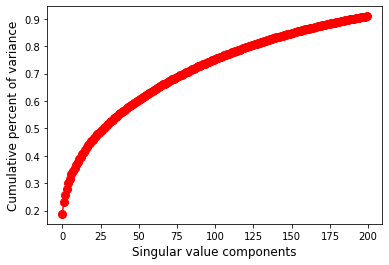

In [0]:
# plot variance expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [0]:
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold

model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

kf = KFold(n_splits=10)

for train_index, test_index in kf.split(latent_matrix_ratings_df):
  model_knn.fit(latent_matrix_ratings_df.iloc[train_index])
  distances, indices = model_knn.kneighbors(latent_matrix_ratings_df.iloc[test_index], n_neighbors= 1)
  print('Average Distance : %lf'%(np.sum(distances)/test_index.shape[0]))

Average Distance : 0.372574
Average Distance : 0.281834
Average Distance : 0.249258
Average Distance : 0.176390
Average Distance : 0.145043
Average Distance : 0.108674
Average Distance : 0.171697
Average Distance : 0.149032
Average Distance : 0.104618
Average Distance : 0.062887


**Memory based Content Filtering**

- TF-idf matrix with K-nearest Neighbors

In [0]:
Final[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),pixar pixar fun Adventure Animation Children C...
1,2,Jumanji (1995),fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men (1995),moldy old Comedy Romance


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(Final['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())
tfidf_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1635,1636,1637,1638,1639,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149152,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.114569,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.310543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


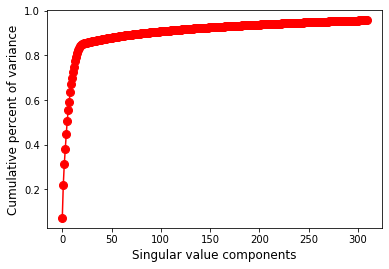

In [0]:
svd = TruncatedSVD(n_components=310)
latent_matrix_content_tfidf = svd.fit_transform(tfidf_df)
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [0]:
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold

model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

kf = KFold(n_splits=10)

for train_index, test_index in kf.split(latent_matrix_content_tfidf):
  model_knn.fit(latent_matrix_content_tfidf[train_index])
  distances, indices = model_knn.kneighbors(latent_matrix_content_tfidf[test_index], n_neighbors= 1)
  print('Average Distance : %lf'%(np.sum(distances)/test_index.shape[0]))

Average Distance : 0.060933
Average Distance : 0.044646
Average Distance : 0.031193
Average Distance : 0.026149
Average Distance : 0.042680
Average Distance : 0.027408
Average Distance : 0.026674
Average Distance : 0.024818
Average Distance : 0.028144
Average Distance : 0.015782


**Model based Collaborative Filtering**

- Singular value decomposition (SVD)
- Non-negative matrix factorization (NMF)

In [0]:
from surprise import SVD, NMF, KNNBasic
from surprise.model_selection import KFold
from surprise import accuracy
from surprise import Reader, Dataset

In [0]:
ratings_dict = {'movieID': list(ratings.movieId), 'userID': list(ratings.userId), 'rating': list(ratings.rating)}
df = pd.DataFrame(ratings_dict)

reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(df[['userID', 'movieID', 'rating']], reader)

In [0]:
data.df

,userID,movieID,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [0]:
kf = KFold(n_splits=10)

algo = SVD()

for trainset, testset in kf.split(data):
  algo.fit(trainset)
  predictions = algo.test(testset)
  accuracy.rmse(predictions, verbose=True)
  

RMSE: 0.8610
RMSE: 0.8679
RMSE: 0.8715
RMSE: 0.8734
RMSE: 0.8657
RMSE: 0.8733
RMSE: 0.8631
RMSE: 0.8557
RMSE: 0.8834
RMSE: 0.8711


In [0]:
algo = NMF()

for trainset, testset in kf.split(data):
  algo.fit(trainset)
  predictions = algo.test(testset)
  accuracy.rmse(predictions, verbose=True)

RMSE: 0.9068
RMSE: 0.9293
RMSE: 0.9012
RMSE: 0.9050
RMSE: 0.9211
RMSE: 0.9223
RMSE: 0.9236
RMSE: 0.9047
RMSE: 0.9174
RMSE: 0.9138


In [0]:
algo = KNNBasic()

for trainset, testset in kf.split(data):
  algo.fit(trainset)
  predictions = algo.test(testset)
  accuracy.rmse(predictions, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9297
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9362
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9385
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9488
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9439
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9337
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9521
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9482
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9443
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9345
